In [1]:
import numpy as np
import numpy as np
import numba
import matplotlib.pyplot as plt

In [19]:
dt = 0.1 # ms 0.1ms is reasonable
duration = 3500  # Simulation duration (ms)
seed = 0  # seed for RNG of noise and ICs
T = duration
t = np.arange(0,T,dt)

# neural mass model parameters
tau_u = 10   # excitatory time constant
tau_p = 10   # PV time constant
tau_s = 10   # SST time constant
tau_d1 = 1500 # replenishment time constant
tau_d2 = 20   # depletion time constant
t0 = 300
dur = 100
isi = 300

w_ee = 1.1 # local E-E coupling
w_ep = 2.  # local E-PV coupling
w_es = 1.  # local E-SST coupling
w_pe = 1.  # local PV-E coupling
w_pp = 2.  # local PV-PV coupling
w_ps = 2.  # local PV-SST coupling
w_se = 6.  # local SST-E coupling
w_sp = 0.  # local SST-PV coupling
w_ss = 0.  # local SST-SST coupling
r_u = 3.  # excitatory gain
r_p = 3.  # PV gain
r_s = 3.  # SST gain
u_th = 0.7 # excitatory firing threshold
p_th = 1.0  # PV firing threshold
s_th = 1.0  # SST firing threshold
q = 5  # input amplitude

opt_pv  = -2 # optogenetic PV suppression variable
opt_sst = -1 # optogenetic SST suppression variable


g = np.ones((len(t))) # depressing term, g = D for three unit model
I_ext = np.zeros((len(t))) #Input   
I = np.zeros((len(t))) #Thalamic adapted input I_ext * g


In [20]:
# Functions for input and optogenetic stimulation

def thalamic_input(t, dt, input_time, tau_q = 10, q = 1.3):
    I_t = np.zeros(len(t))
    for i in range(1,len(t)):
        I_t[i] = I_t[i-1] + (dt/tau_q) * (-I_t[i-1])
        for j in range(len(input_time)):
            if t[i]==input_time[j]:
                I_t[i] =q
    return I_t

def I_opto(t,laser_on_times,val=-1):
    I_opto = np.zeros((len(t)))
    laser_on_times = np.asarray(laser_on_times)*10
    for i in range(len(laser_on_times)):
        I_opto[laser_on_times[i][0]:laser_on_times[i][1]] = val
    return I_opto


In [21]:
#Rectifying 
def f(x, r):
    if x<=0:
        return 0
    elif x<=1/r:
        return r*x
    else:
        return 1

In [22]:
def single_unit_simulation(t,dt,tau_d1,tau_d2,w_ee,w_ep,w_es,w_pe,w_pp,w_ps,w_se,w_sp,w_ss,q,I_ext,u_th,p_th,s_th,r_u,r_p,r_s,tau_u,tau_p,tau_s,Iopt_PV,Iopt_SST,opt_gen_flag):
    u= np.zeros((len(t)))
    p= np.zeros((len(t)))
    s= np.zeros((len(t)))
    g= np.ones((len(t)))
    
    # Note: Positive optogenetic numbers correspond to activation and negative numbers correspond to inactivation       
    for i in range(len(t)-1):
        g[i+1] = g[i] + dt * (((1-g[i])/tau_d1)-((g[i] * I_ext[i])/tau_d2))
        u[i+1] = u[i] + (-u[i] + f(w_ee*u[i] - w_ep*p[i] - w_es*s[i] + q*g[i]*I_ext[i]  - u_th,r_u))*dt/tau_u
        p[i+1] = p[i] + (-p[i] + f(w_pe*u[i] - w_pp*p[i] - w_ps*s[i] + Iopt_PV[i] + q*g[i]*I_ext[i] - p_th,r_p))*dt/tau_p
        s[i+1] = s[i] + ( -s[i] + f(w_se*u[i] - w_sp*p[i] - w_ss*s[i] + Iopt_SST[i] - s_th,r_s))*dt/tau_s
    return g,u,p,s

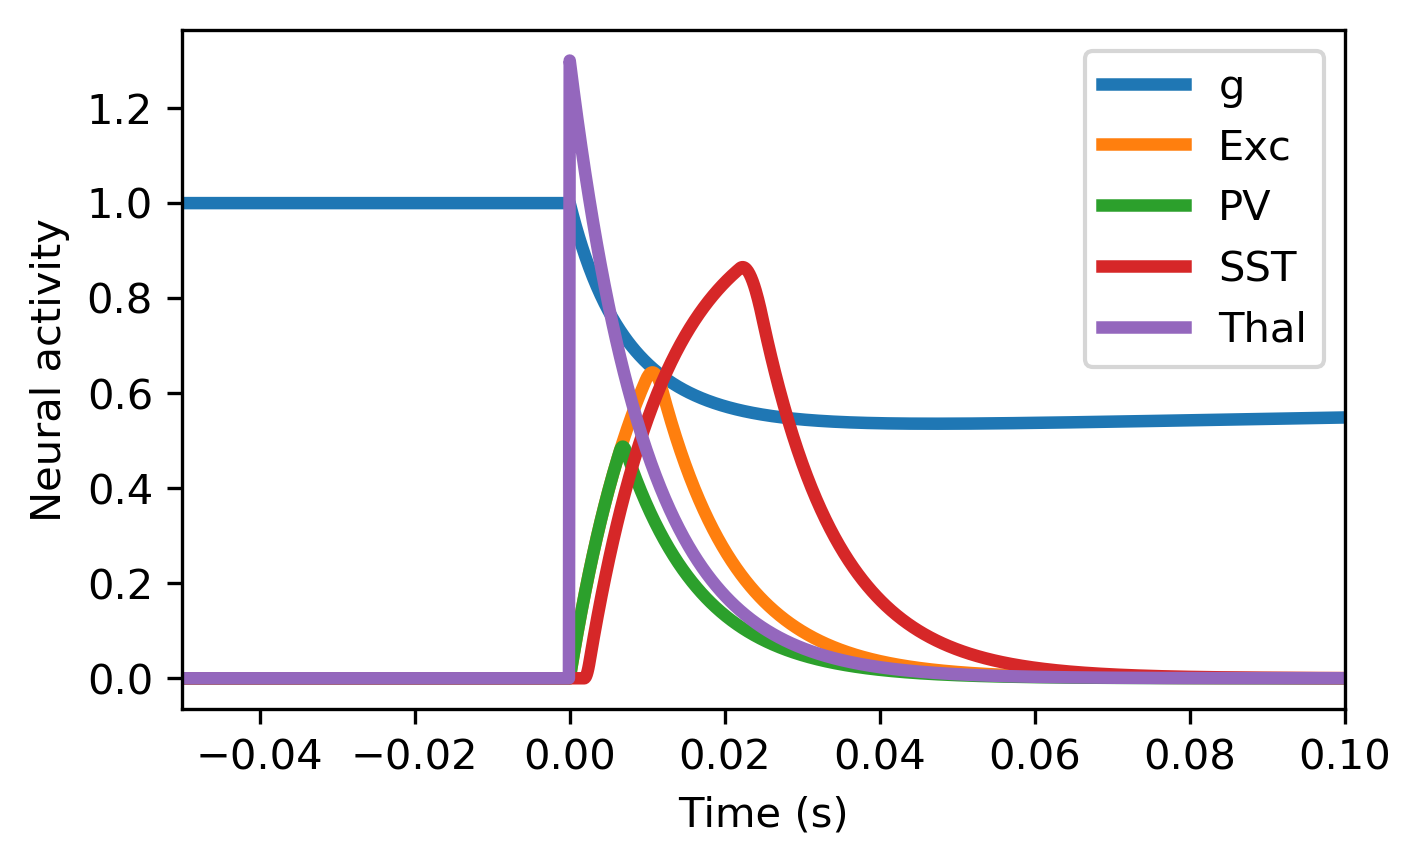

In [45]:
#Fig 1. A. Model of the PV-SST-Exc circuit

input_tones = [100]
I_ext = thalamic_input(t, dt, input_tones, tau_q = 10, q = 1.3)#*3.0
opt_pv = np.zeros((len(t)))
opt_sst = np.zeros((len(t)))
g,u,p,s = single_unit_simulation(t,dt,tau_d1,tau_d2,w_ee,w_ep,w_es,w_pe,w_pp,w_ps,w_se,w_sp,w_ss,q,I_ext,u_th,p_th,s_th,r_u,r_p,r_s,tau_u,tau_p,tau_s,opt_pv,opt_sst,opt_gen_flag=0)

tt = (t-100.)/1000.

fig, ax = plt.subplots(figsize=(5, 3), dpi=300)
plt.plot(tt,g,label="g",linewidth=3.0)
plt.plot(tt,u,label="Exc",linewidth=3.0)
plt.plot(tt,p,label="PV",linewidth=3.0)
plt.plot(tt,s,label="SST",linewidth=3.0)
plt.plot(tt,I_ext,label="Thal",linewidth=3.0)
plt.xlabel("Time (s)")
plt.ylabel("Neural activity")
#plt.title("Fig 1. Model of the PV-SST-Exc circuit")
#plt.xlim([0,300])
plt.xlim([-0.05,0.1])
plt.legend()
#plt.savefig('../Figures/New_15_12_20/Fig1B.png')
plt.show()  

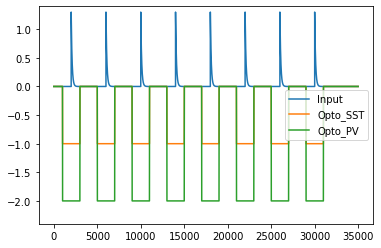

In [7]:
# Fig 3. The effect of optogenetic manipulations on adaptation to repeated tones

input_tones = [200,600,1000,1400,1800,2200,2600,3000]

I_ext = thalamic_input(t, dt, input_tones, tau_q = 10, q = 1.3)

laser_on_times =[]
for i in range(len(input_tones)):
    laser_on_times.append([input_tones[i]-100,input_tones[i]+100])

I_sst =  I_opto(t,laser_on_times,val=-1)
I_pv =  I_opto(t,laser_on_times,val=-2)

plt.plot(I_ext,label="Input")
plt.plot(I_sst,label= "Opto_SST") 
plt.plot(I_pv,label = "Opto_PV")
plt.ylim(-2.4,1.4)
plt.legend()
plt.show()


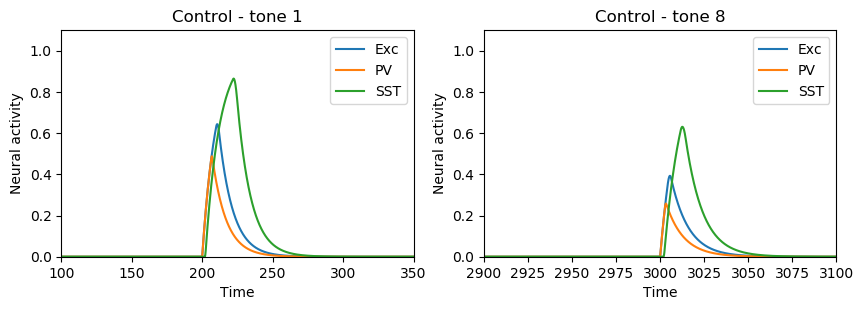

In [8]:
#Control

opt_pv = np.zeros((len(t)))
opt_sst = np.zeros((len(t)))
control_g,control_u,control_p,control_s = single_unit_simulation(t,dt,tau_d1,tau_d2,w_ee,w_ep,w_es,w_pe,w_pp,w_ps,w_se,w_sp,w_ss,q,I_ext,u_th,p_th,s_th,r_u,r_p,r_s,tau_u,tau_p,tau_s,opt_pv,opt_sst,opt_gen_flag=0)
fig, ax = plt.subplots(1,2,figsize=(10, 3), dpi=100)
ax[0].plot(t,control_u,label="Exc")
ax[0].plot(t,control_p,label="PV")
ax[0].plot(t,control_s,label="SST")
ax[0].set(xlabel = "Time", ylabel="Neural activity",ylim =[0,1.1],xlim = [100,350],title="Control - tone 1")
ax[0].legend()


ax[1].plot(t,control_u,label="Exc")
ax[1].plot(t,control_p,label="PV")
ax[1].plot(t,control_s,label="SST")
ax[1].set(xlabel = "Time", ylabel="Neural activity",ylim =[0,1.1],xlim = [2900,3100],title="Control - tone 8")
ax[1].legend()
plt.show()   

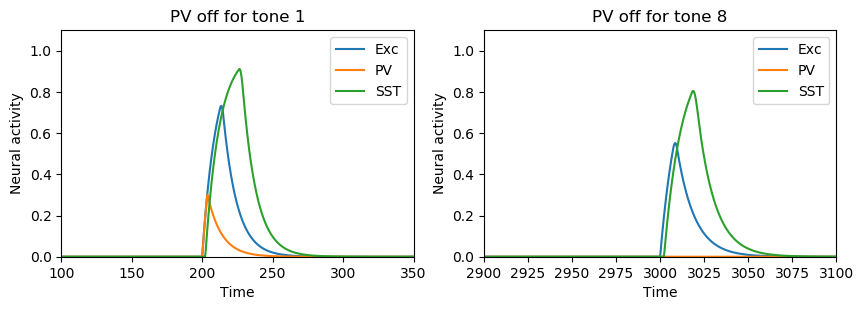

In [9]:
#PV Off
opt_pv = I_opto(t,laser_on_times,val=-2)
opt_sst = np.zeros((len(t)))
opt_gen_flag = 1
pv_g,pv_u,pv_p,pv_s = single_unit_simulation(t,dt,tau_d1,tau_d2,w_ee,w_ep,w_es,w_pe,w_pp,w_ps,w_se,w_sp,w_ss,q,I_ext,u_th,p_th,s_th,r_u,r_p,r_s,tau_u,tau_p,tau_s,opt_pv,opt_sst,opt_gen_flag)
fig, ax = plt.subplots(1,2,figsize=(10, 3), dpi=100)

ax[0].plot(t,pv_u,label="Exc")
ax[0].plot(t,pv_p,label="PV")
ax[0].plot(t,pv_s,label="SST")
ax[0].set(xlabel = "Time", ylabel="Neural activity",ylim =[0,1.1],xlim = [100,350],title="PV off for tone 1")
ax[0].legend()


ax[1].plot(t,pv_u,label="Exc")
ax[1].plot(t,pv_p,label="PV")
ax[1].plot(t,pv_s,label="SST")
ax[1].set(xlabel = "Time", ylabel="Neural activity",ylim =[0,1.1],xlim = [2900,3100],title="PV off for tone 8")
ax[1].legend()
plt.show() 

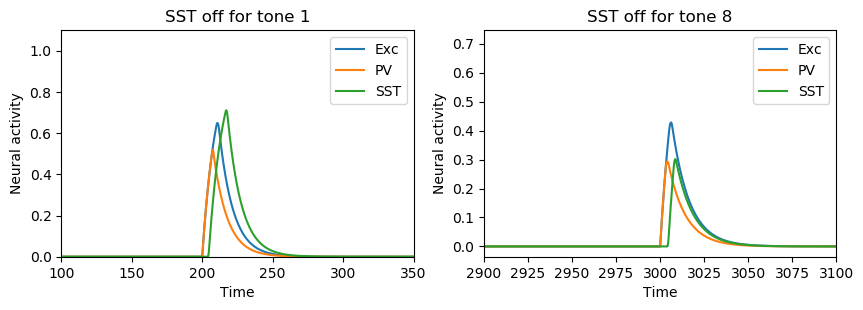

In [10]:
#SST Off
opt_pv = np.zeros((len(t)))
opt_sst = I_opto(t,laser_on_times,val=-1)
opt_gen_flag = 2
sst_g,sst_u,sst_p,sst_s = single_unit_simulation(t,dt,tau_d1,tau_d2,w_ee,w_ep,w_es,w_pe,w_pp,w_ps,w_se,w_sp,w_ss,q,I_ext,u_th,p_th,s_th,r_u,r_p,r_s,tau_u,tau_p,tau_s,opt_pv,opt_sst,opt_gen_flag)
fig, ax = plt.subplots(1,2,figsize=(10, 3), dpi=100)
ax[0].plot(t,sst_u,label="Exc")
ax[0].plot(t,sst_p,label="PV")
ax[0].plot(t,sst_s,label="SST")
ax[0].set(xlabel = "Time", ylabel="Neural activity",ylim =[0,1.1],xlim = [100,350],title="SST off for tone 1")
ax[0].legend()


ax[1].plot(t,sst_u,label="Exc")
ax[1].plot(t,sst_p,label="PV")
ax[1].plot(t,sst_s,label="SST")
ax[1].set(xlabel = "Time", ylabel="Neural activity",xlim = [2900,3100],title="SST off for tone 8")
ax[1].legend()
plt.show() 

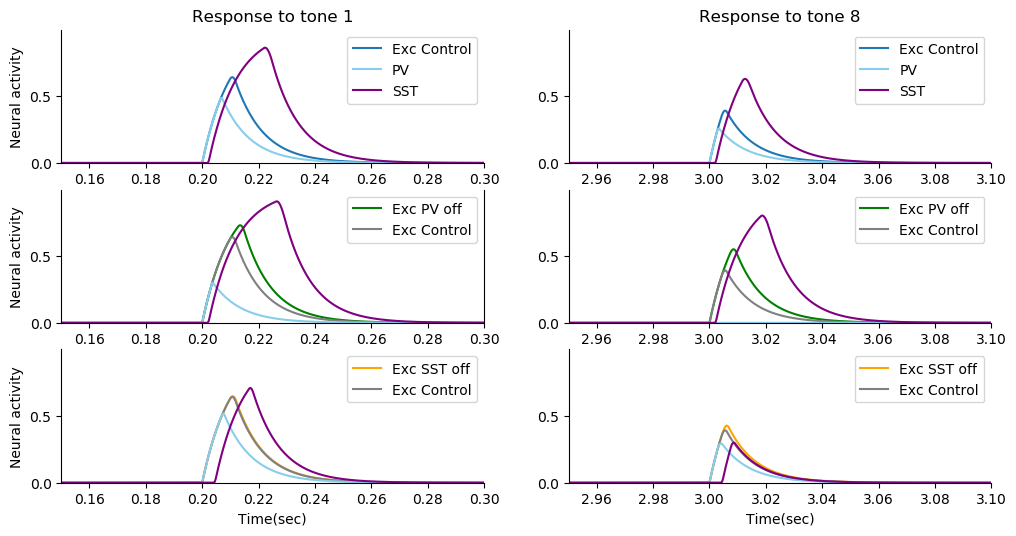

In [11]:
fig, ax = plt.subplots(3,2,figsize=(12, 6), dpi=100)
t = np.arange(0,3.5,0.0001)

ax[0][0].plot(t,control_u,label="Exc Control")
ax[0][0].plot(t,control_p,label="PV",color="skyblue")
ax[0][0].plot(t,control_s,label="SST",color="purple")
ax[0][0].set(title = "Response to tone 1", ylabel="Neural activity",xlim = [0.15,0.30],ylim=[0,1],yticks =(np.arange(0, 1, step=0.5)))
ax[0][0].spines['top'].set_visible(False)
ax[0][0].spines['right'].set_visible(False) 
ax[0][0].legend()


ax[0][1].plot(t,control_u,label="Exc Control")
ax[0][1].plot(t,control_p,label="PV",color="skyblue")
ax[0][1].plot(t,control_s,label="SST",color="purple")
ax[0][1].set(title = "Response to tone 8", xlim = [2.950,3.100],ylim=[0,1],yticks =(np.arange(0, 1, step=0.5)))
ax[0][1].spines['top'].set_visible(False)
ax[0][1].spines['right'].set_visible(False)
ax[0][1].legend()

ax[1][0].plot(t,pv_u,label="Exc PV off",color="green")
ax[1][0].plot(t,control_u,label="Exc Control",color="Gray")
ax[1][0].plot(t,pv_p,color="skyblue")
ax[1][0].plot(t,pv_s,color="purple")
ax[1][0].set( ylabel="Neural activity",xlim = [0.15,0.30],ylim=[0,1],yticks =(np.arange(0, 1, step=0.5)))
ax[1][0].spines['top'].set_visible(False)
ax[0][0].spines['right'].set_visible(False) 
ax[1][0].legend()


ax[1][1].plot(t,pv_u,label="Exc PV off",color="green")
ax[1][1].plot(t,control_u,label="Exc Control",color="Gray")
ax[1][1].plot(t,pv_p,color="skyblue")
ax[1][1].plot(t,pv_s,color="purple")
ax[1][1].set(xlim = [2.950,3.100],ylim=[0,1],yticks =(np.arange(0, 1, step=0.5)))
ax[1][1].spines['top'].set_visible(False)
ax[1][1].spines['right'].set_visible(False)
ax[1][1].legend()

ax[2][0].plot(t,sst_u,label="Exc SST off",color="orange")
ax[2][0].plot(t,control_u,label="Exc Control",color="Gray")
ax[2][0].plot(t,sst_p,color="skyblue")
ax[2][0].plot(t,sst_s,color="purple")
ax[2][0].set(xlabel = "Time(sec)", ylabel="Neural activity",xlim = [0.15,0.30],ylim=[0,1],yticks =(np.arange(0, 1, step=0.5)))
ax[2][0].spines['top'].set_visible(False)
ax[2][0].spines['right'].set_visible(False) 
ax[2][0].legend()


ax[2][1].plot(t,sst_u,label="Exc SST off",color="orange")
ax[2][1].plot(t,control_u,label="Exc Control",color="Gray")
ax[2][1].plot(t,sst_p,color="skyblue")
ax[2][1].plot(t,sst_s,color="purple")
ax[2][1].set(xlabel="Time(sec)", xlim = [2.950,3.100],ylim=[0,1],yticks =(np.arange(0, 1, step=0.5)))
ax[2][1].spines['top'].set_visible(False)
ax[2][1].spines['right'].set_visible(False) 

ax[2][1].legend()
plt.show() 

In [14]:
    
#Finding maximum values in firing rates
def find_max(fir_rate,input_tones,dt,interval): 
    max_values = np.zeros((len(fir_rate),len(input_tones)))
    time_adjust = int(1/dt)   
    for r in range(len(fir_rate)):
        for i in range(len(input_tones)): 
            start = int(input_tones[i]*time_adjust)
            end = int((input_tones[i] + interval)*time_adjust)
            max_values[r][i] = np.max(fir_rate[r][start:end])
        max_values[r] = max_values[r][np.argsort(-max_values[r])]
    return max_values


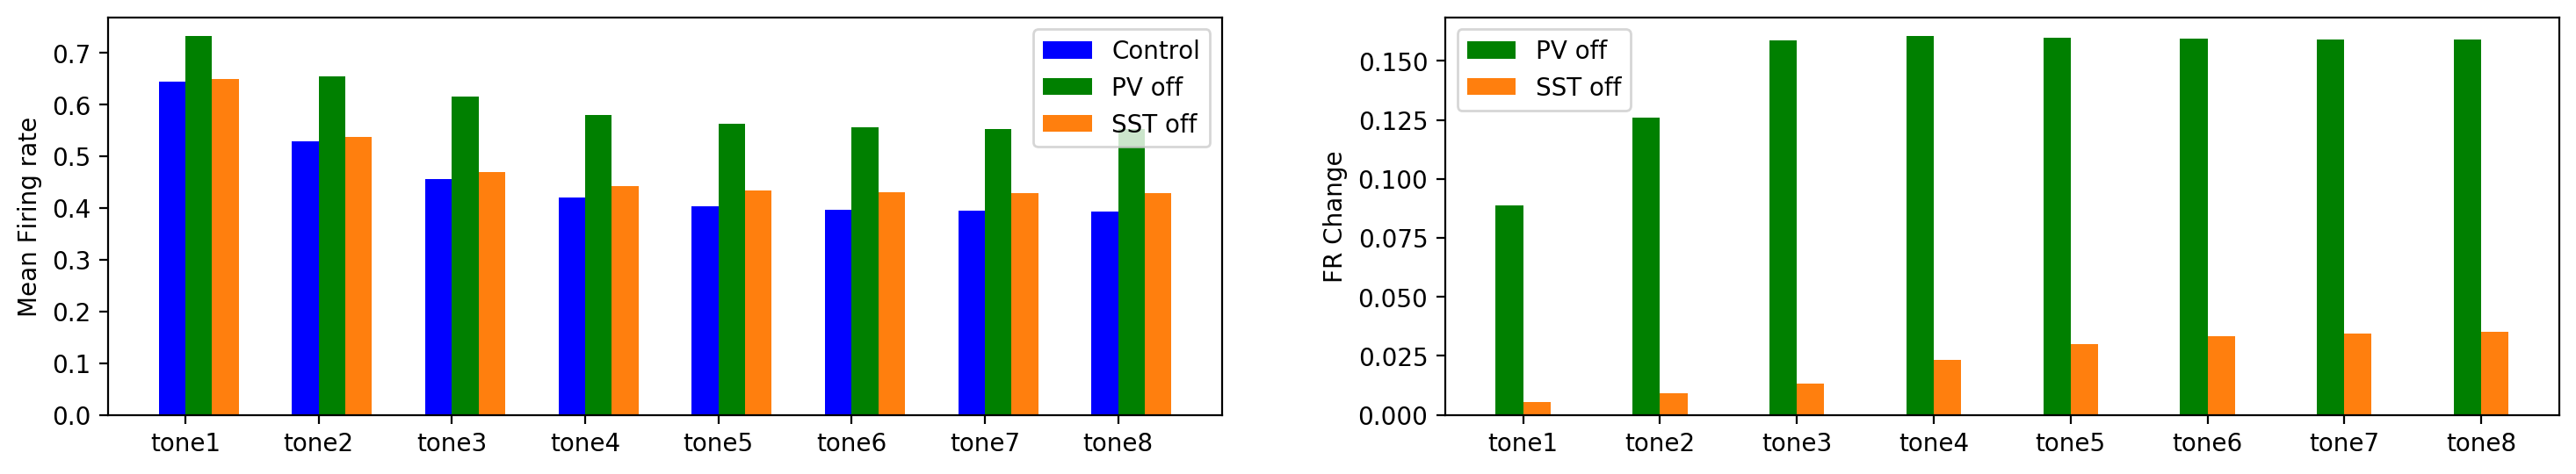

In [31]:
max_values = find_max([control_u,pv_u,sst_u],input_tones,dt,200)
labels = ['tone1', 'tone2', 'tone3', 'tone4', 'tone5', 'tone6', 'tone7', 'tone8']
control = max_values[0]
pv_off  = max_values[1]
sst_off = max_values[2]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(1,2,figsize=(18,3),dpi=200)
c1 = ax[0].bar(x - width/2, control, width, label='Control',color="blue")
p1 = ax[0].bar(x + (width/2), pv_off, width, label='PV off',color="green")
s1 = ax[0].bar(x + 3*(width/2), sst_off, width, label='SST off',color='C1')
ax[0].set_ylabel('Mean Firing rate')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].legend()

diff_p = ax[1].bar(x - (width/2), pv_off-control, width, label='PV off',color="green")
diff_s = ax[1].bar(x + (width/2), sst_off-control, width, label='SST off',color='C1')
ax[1].set_ylabel('FR Change')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].legend()

plt.show()